# MLP Example on 2D Data

In this notebook, we will demonstrate how to use the JLNN to build a simple Multi-layer Perceptron to classify the handcrafted dataset. First we will import all the required modules. We use `PyPlot` to plot the visualizations. We will also import necessary layers and a network essembler `SquentialNet` to build our simple architecture.

In [1]:
Pkg.update()
Pkg.add("PyPlot")
include("layers/SquareLossLayer.jl")
include("layers/FCLayer.jl")
include("layers/ReLu.jl")
include("layers/Tanh.jl")
include("layers/SequnetialNet.jl")
using PyPlot

INFO: Updating METADATA...
INFO: Updating Lint master...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done


Diff: [0.0; 0.0; 2.0; 5.0]
(
[14.5],

[0; 1; 1; 1])
dldy:[0.0; 0.0; 2.0; 5.0]
[0.0; 0.0; 2.0; 5.0]
FCLayer(2,[-6.60359 -1.9575 -2.30305; 0.489011 0.928404 -0.123313; -7.32645 1.34103 -6.78791],[0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,0.0],[0.0 0.0 0.0; 0.0 0.0 0.0])
[3.0 22.0 21.0; 7.0 46.0 45.0]
[56.0 110.0; 74.0 144.0]
[26.0 30.0 34.0; 38.0 44.0 50.0; 12.0 14.0 16.0]
[1.0 2.0; 0.0 3.0; 1.0 0.0; 0.0 0.0]
[2.0 3.0; 0.0 5.0; 3.0 0.0; 0.0 0.0]
[0.761594 0.964028; -0.761594 0.995055; 0.761594 -0.964028; -0.995055 -0.995055]
[0.839949 0.211952; 0.839949 0.0493302; 1.25992 0.423905; 0.0197321 0.0197321]


## Data Generation

We will make a dataset with two-dimensional data with two classes. In the function `makeData`, we will make such data set according to a specififed shape. `makeData` will return a tuple of `(trX, trY)`, where `trX` is a `nx2` array that contains `n` data poitns and `trY` is an `n` dimensional vectr that cotnains the label. We use number `0` and `1` to label the two classes.

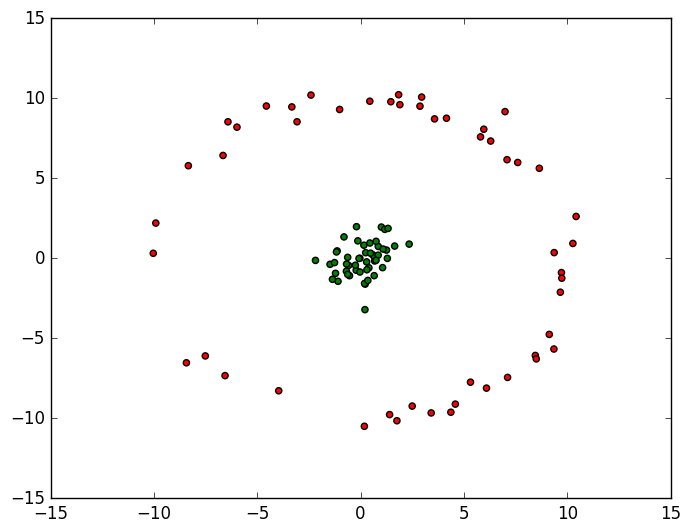

PyObject <matplotlib.collections.PathCollection object at 0x323e7d2d0>

  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/Grendel/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/Grendel/.juli

In [2]:
function makeData(N1, N2)
    N = N1+ N2

    points = Array{Float64}(N,2)

    ## gaussian center
    center, sigma = [0,0], [1 0; 0 1]
    points[:,1] = randn(N, 1)
    points[:,2] = randn(N, 1)

    ## generate the spherical
    r = 10. 
    for i in (N1+1) : N
        theta = randn(1, 1)[1] * 2 * pi
        for j in 1 : 2
            if(j % 2 == 0)
                points[i,j] = r * sin(theta) + randn(1, 1)[1] * 0.5
            else
                points[i,j] = r * cos(theta) + randn(1, 1)[1] * 0.5
            end
        end
    end

    Y = ones(N, 1)
    Y[1:N1, :] = zeros(N1,1)

    ALL = hcat(points, Y)
    ALL = ALL[randperm(N),:]

    trX = ALL[:, 1:2]
    trY = ALL[:, 3]
    return trX, trY
end

trX, trY = makeData(50,50)
title("Data")
scatter(trX[:,1], trX[:,2], c=map(x-> (x >0)?"r":"g",trY))


# Network Structure

Our network will have the simple architecure like the following:

![Structure Visualization using Tensorflow Playground](img/simple_net_structure.png)

We will use three fully connected layers to implement the two hidden layer. The first fully connected layer connects input to the first hidden layer. The second fully connected layer connects between two hidden layers. The third fully connect layer connects the last hidden layer to the output. 

Since we are working on a classification problem. Output of the network is piped into a `tanh` layer, so that it will become closed to either `1` or `-1` when it's large in both the positive or negative side. Then we predict the data into class `0` if the value of the output layer is less or equal to zero; `1` will be predicted if the output value is close to one.

In our example, simple square loss will be used. It has the following formua:

$$\mathcal{L} = \frac{1}{2}(y-t)^T(y-t)$$

where $y$ is the value of the output layer (`Tanh` in this case) and $t$ is the label. The derivative of this loss layer is:
$$\frac{\partial}{\partial y}\mathcal{L} = y - t$$

In [3]:
function build_net()
    layers = [
        FCLayer(2,4;init_type="Random"),
        ReLu(),
        FCLayer(4,2;init_type="Random"),
        ReLu(),
        FCLayer(2,1;init_type="Random"),
        Tanh()
    ]
    criteria = SquareLossLayer()
    net = SequentialNet(layers, criteria)
    return net
end
net = build_net()


SequentialNet(Layer[FCLayer(2,[0.222648 -0.30116 -0.406726 -0.034574; 0.435699 -0.208844 0.257788 0.358842; 0.217083 0.376094 -0.0335772 0.470124],[0.0,0.0],[0.0,0.0,0.0,0.0],[0.0,0.0,0.0,0.0],[0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]),ReLu(1.0,Float64[],Float64[],Float64[],Float64[]),FCLayer(4,[0.276385 0.30409; 0.219134 0.132257; … ; 0.378129 0.294181; 0.419314 0.403396],[0.0,0.0,0.0,0.0],[0.0,0.0],[0.0,0.0],[0.0 0.0; 0.0 0.0; 0.0 0.0; 0.0 0.0]),ReLu(1.0,Float64[],Float64[],Float64[],Float64[]),FCLayer(2,[-0.379383; 0.466681; 0.248044],[0.0,0.0],[0.0],[0.0],[0.0; 0.0]),Tanh(Float64[],Float64[],Float64[])],SquareLossLayer(Float64[],Float64[]))

# Training / Optimization

TODO write a description about the basic gradient descent and learning rate we chose

In [17]:
function train(net::SequentialNet, X, Y; batch_size::Int64 = 64, ttl_epo::Int64 = 10, lrSchedule = (x -> 0.01), verbose = 0)
    local N = size(Y)[1]
    local batch=0
    local epo_losses = []
    local all_losses = []
    local all_accu   = []
    for epo = 1:ttl_epo
        local num_batch = ceil(N/batch_size)
        if verbose > 0
            println("Epo $(epo) num batches : $(num_batch)")
        end
        epo_cor = 0
        for bid = 0:num_batch
            batch += 1
            local sidx::Int = convert(Int64, bid*batch_size+1)
            local eidx::Int = convert(Int64, min(N, (bid+1)*batch_size))
            local batch_X = X[sidx:eidx,:]
            local batch_Y = Y[sidx:eidx,:]
            loss, pred = forward(net, batch_X, batch_Y)
            loss = mean(loss)
            epo_cor  += length(filter(e -> e == 0, pred - batch_Y))
            local acc = length(filter(e -> e == 0, pred - batch_Y)) / batch_size
            backward(net, batch_Y)
            for i = 1:length(net.layers)
                local layer = net.layers[i]
                local gradi = lrSchedule(epo) * gradient(layer) / batch_size
                local theta = getParam(layer) - gradi
                if verbose > 1
                    print("Layer $(i)")
                    print("\tGradient: $(sum(abs(theta - getLDiff(layer))))")
                    if verbose > 1
                        print("\tLastloss: $(sum(abs(layer.last_loss)))")
                    end
                    println()
                end
                setParam!(layer, theta)
            end
            append!(all_losses, loss)
            if verbose > 1
                println("[$(bid)/$(num_batch)]Loss is: $(loss)\tAccuracy:$(acc)")
            end
        end
        local epo_loss = mean(all_losses)
        local epo_accu = epo_cor / N
        append!(all_accu, epo_accu)
        append!(epo_losses, epo_loss)
        # @printf "Epo %d has loss:\t%.3f\taccurarcy:%.3f" epo epo_loss epo_accu
        if verbose > 0
            println("Epo $(epo) has loss :$(epo_loss)\t\taccuracy : $(epo_accu)")
        end
    end
    return epo_losses, all_losses, all_accu
end

train (generic function with 1 method)

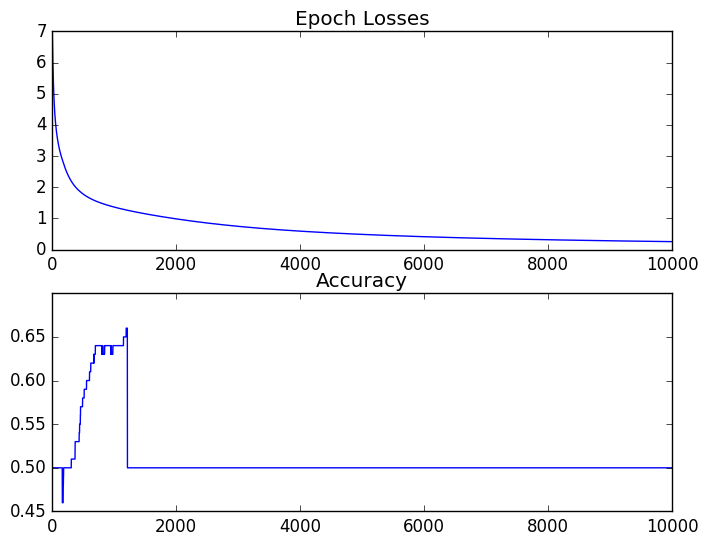

PyObject <matplotlib.text.Text object at 0x3265a0110>

In [24]:
net = build_net()
epo_losses, batch_losses, epo_accu = train(net, trX, trY, ttl_epo = 1000; batch_size = 100,
               lrSchedule = x -> 0.03)
subplot(211)
plot(1:length(epo_losses), epo_losses)
title("Epoch Losses")
subplot(212)
plot(1:length(epo_accu), epo_accu)
title("Accuracy")
# show()